### Loading packages

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

import theano
# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


### Loading surface points from repository:

With pandas we can do it directly from the web and with the right args we can directly tidy the data in gempy style:

In [2]:
Moureze_points = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Moureze/Moureze_Points.csv', sep=';',
                         names=['X', 'Y', 'Z', 'G_x', 'G_y', 'G_z', '_'], header=0, )
Sections_EW = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Moureze/Sections_EW.csv', sep=';',
                         names=['X', 'Y', 'Z', 'ID', '_'], header=1).dropna()
Sections_NS = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Moureze/Sections_NS.csv', sep=';',
                         names=['X', 'Y', 'Z', 'ID', '_'], header=1).dropna()

Extracting the orientatins:

In [3]:
mask_surfpoints = Moureze_points['G_x'] < -9999
surfpoints = Moureze_points[mask_surfpoints]
orientations = Moureze_points[~mask_surfpoints]

Giving an arbitrary value name to the surface

In [4]:
surfpoints['surface'] = 0.0
orientations['surface'] = 0.0

In [5]:
surfpoints.tail()

,X,Y,Z,G_x,G_y,G_z,_,surface
3425,177.428558,155.904465,-152.007,-99999.0,-99999.0,-99999.0,0.045217,0.0
3426,89.924927,86.352005,-120.026,-99999.0,-99999.0,-99999.0,0.067264,0.0
3427,75.935799,116.717010,-140.023,-99999.0,-99999.0,-99999.0,0.783988,0.0
3428,177.964096,233.829971,-148.831,-99999.0,-99999.0,-99999.0,0.523201,0.0
3429,46.487995,17.739241,-148.019,-99999.0,-99999.0,-99999.0,0.110549,0.0


In [6]:
orientations.tail()

,X,Y,Z,G_x,G_y,G_z,_,surface
3409,47.970890,129.885971,-132.010,-0.453523,-0.849487,0.269609,0.016933,0.0
3420,175.944580,293.731140,-138.019,0.217228,-0.884429,0.413035,0.444558,0.0
3421,203.969635,367.725098,-150.011,0.217373,-0.971044,-0.099104,0.708855,0.0
3422,133.925903,225.623962,-146.756,0.318182,-0.872684,-0.370381,0.126039,0.0
3430,290.000000,180.000000,-103.539,0.126294,-0.192654,0.973105,0.679096,0.0


### Data initialization:


Suggested size of the axis-aligned modeling box:

Origin: -5 -5 -200

Maximum: 305 405 -50

Suggested resolution: 2m (grid size 156 x 206 x 76)

### Only using one orientation because otherwhise it gets a mess

In [7]:
# Number voxels
np.array([156, 206, 76]).prod()

2442336

In [8]:
resolution_requ = [156, 206, 76]
resolution = [77, 103, 38]
geo_model = gp.create_model('Moureze')
geo_model = gp.init_data(geo_model, 
                         extent=[-5,305,-5,405,-200, -50], resolution=resolution_requ,
                         surface_points_df=surfpoints, orientations_df=orientations,
                         surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


Now we can see how the data looks so far:

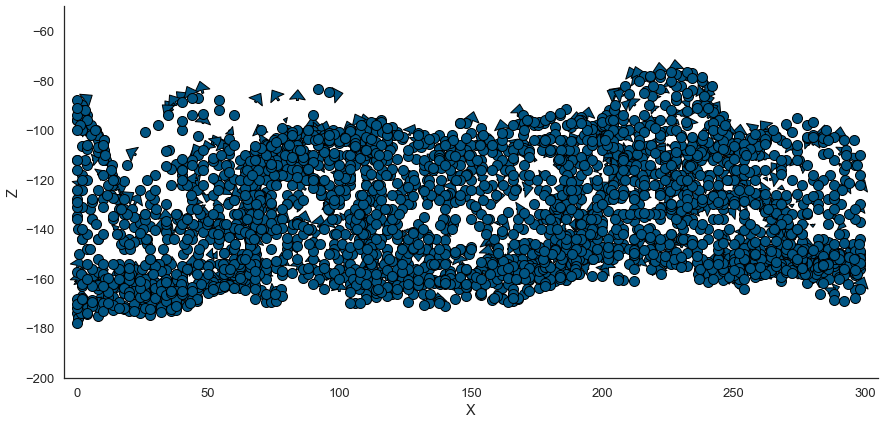

In [9]:
gp.plot.plot_data(geo_model, direction='y')

In [10]:
gp.set_interpolation_data(geo_model, 
                          theano_optimizer='fast_run')

Setting kriging parameters to their default values.
Compiling theano function...


/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            535.444
$C_o$            6826.19
drift equations   [3, 3]


The default range is always the diagonal of the extent. Since in this model data is very close we will need to reduce the range to 5-10% of that value:

In [11]:
val=.1
geo_model.interpolator.theano_graph.a_T.set_value(val)
geo_model.interpolator.theano_graph.a_T_surface.set_value(val)


In [12]:
gp.compute_model(geo_model, set_solutions=True, sort_surfaces=False)

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=5.62099e-11): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
../../../gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')



Lithology ids 
  [2. 2. 2. ... 1. 1. 1.] 

### Time
#### 300k voxels 3.5k points
- Nvidia 2080: 500 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each), Memory 1 Gb
- CPU  14.2 s ± 82.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each), Memory: 1.3 Gb

#### 2.4 M voxels, 3.5k points

- CPU 2min 33s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) Memory: 1.3 GB
- Nvidia 2080:  1.92 s ± 6.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 1 Gb

#### 2.4 M voxels, 3.5k points 3.5 k orientations
- Nvidia 2080: 2.53 s ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

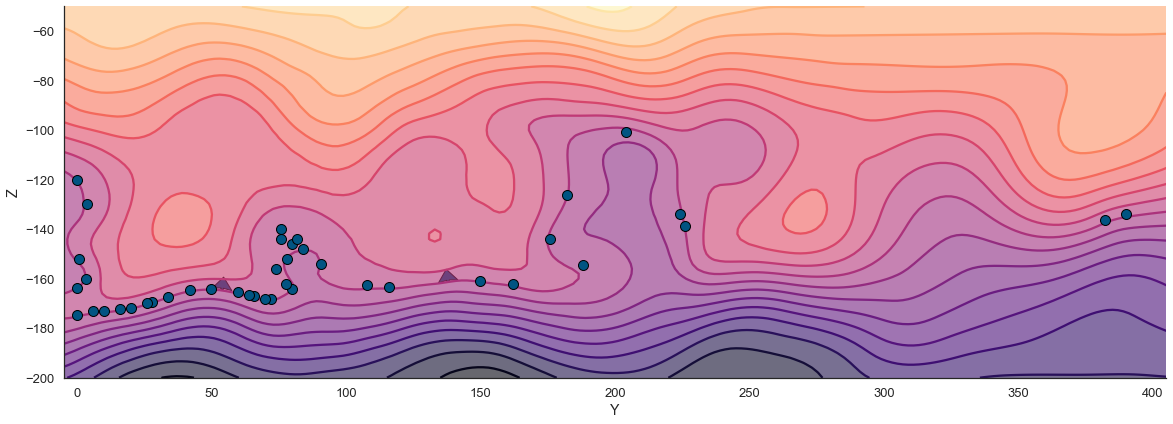

In [13]:
gp.plot.plot_scalar_field(geo_model, 16, series=0, direction='x')

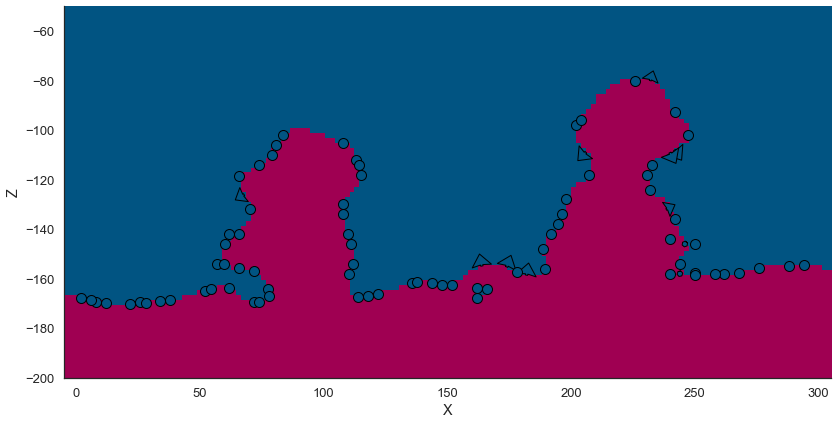

In [14]:
gp.plot.plot_section(geo_model,16, show_data=True, direction='y')

In [15]:
# gp.plot.plot_3D(geo_model, render_data=False)


![](./Moureze.png)

### Export data:

The solution is stored in a numpy array of the following shape. Axis 0 are the scalar fields of each correspondent series/faults in the following order (except basement): 

In [16]:
geo_model.series

,order_series,BottomRelation,isActive
Default series,1,Erosion,True
Basement,2,Erosion,False


For the surfaces, there are two numpy arrays, one with vertices and the other with triangles. Axis 0 is each surface in the order:

In [17]:
geo_model.surfaces

,surface,series,order_surfaces,isActive,color,id
0,0,Default series,1,True,#015482,1
1,basement,Basement,1,True,#9f0052,2


In [18]:
# np.save('Moureze_scalar', geo_model.solutions.scalar_field_matrix)
# np.save('Moureze_ver', geo_model.solutions.vertices)
# np.save('Moureze_edges', geo_model.solutions.edges)
# gp.plot.export_to_vtk(geo_model, 'Moureze')

In [19]:
def write_property_to_gocad_voxet(propertyfilename, propertyvalues):
    """
    This function writes a numpy array into the right format for a gocad
    voxet property file. This assumet there is a property already added to the .vo file,
    and is just updating the file.
    propertyfile - string giving the path to the file to write
    propertyvalues - numpy array nz,ny,nx ordering and in float format
    """
    propertyvalues = propertyvalues.astype('>f4') #big endian
#     array = propertyvalues.newbyteorder()
    propertyvalues.tofile(propertyfilename)

In [20]:
write_property_to_gocad_voxet('moureze_sf_gempy',
                              geo_model.solutions.scalar_field_matrix[0].reshape([156, 206, 76]).ravel('F'))